## This notebook downloads and analyzes EIA's bulk U.S. Electric System Operating Data 
### [https://api.eia.gov/bulk]


In [1]:
# Download EIA's U.S. Electric System Operating Data

import wget
url = "https://api.eia.gov/bulk/EBA.zip"

wget.download(url)

# extract the data
import os
EIA_bulk_data_dir = os.getcwd() + "/EBA"

import zipfile
with zipfile.ZipFile("EBA.zip","r") as zip_ref:
    zip_ref.extractall(EIA_bulk_data_dir)


In [2]:
# CONSTANTS
# Energy types in the grid
ng_list = [
    "WND", # wind
    "SUN", # solar
    "WAT", # hydro
    "OIL", # oil
    "NG",  # natural gas
    "COL", # coal
    "NUC", # nuclear
    "OTH", # other
]

# Renewable energy types
rn_list = ["WND", "SUN", "WAT"]

# Carbon intensity of the energy types, gCO2eq/kWh
carbon_intensity = {
    "WND": 11,
    "SUN": 41,
    "WAT": 24,
    "OIL": 650,
    "NG":  490,
    "COL": 820,
    "NUC": 12,
    "OTH": 230,
}


## Prepare EIA energy source data for processing

### **`prepareEIAData():`** Reads the EIA bulk json file and converts it into a data frame.

Populates `ba_list`, which is a list of all balancing authorities in the US.

Populates `eba_json`, which will be used later for `extractBARange` function.

In [5]:
import scipy
import pickle
import datetime
import json
import math
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

eba_json = None
ba_list = []
ts_list = []
    
# Split json into multiple csv's for manual analysis, view
#
def writeCSV(eba_json):
    numRecords = eba_json.shape[0]
    recordsPerFile = 100
    numFiles = math.ceil(numRecords / recordsPerFile)

    for i in range(numFiles):
        if i == numFiles - 1:
            r = range(recordsPerFile * i + 1, numRecords)
        else:
            r = range(recordsPerFile * i + 1, recordsPerFile * (i + 1))
        print("Writing csv records in {0}".format(r))
        df = eba_json.iloc[r, :]
        df.to_csv("{0}/EBA_sub_{1}.csv".format(EIA_bulk_data_dir,i))

def prepareEIAData():
    global eba_json
    global ba_list
    global ts_list

    # EBA.txt includes time series for power generation from
    # each balancing authority in json format.
    #
    eba_json = pd.read_json("{0}/EBA.txt".format(EIA_bulk_data_dir), lines=True)
    writeCSV(eba_json)

    # Construct list of BAs (ba_list)
    # Construct list of time series (ts_list) using CISO as reference
    #
    series_id_unique = list(eba_json.series_id.unique())
    series_id_unique = list(filter(lambda x: type(x) == str, series_id_unique))
    
    ba_num = 0
    for sid in series_id_unique:
        m = re.search("EBA.(.+?)-", str(sid))
        ba_this = m.group(1)
        if ba_this not in ba_list:
            ba_list.append(ba_this)
            ba_num = ba_num + 1

        if ba_this == "CISO":
            m = re.search("EBA.CISO-([A-Z\-]+\.)([A-Z\.\-]*)", str(sid))
            ts_list.append(m.group(2))
    
    print("EIA data prep done!")

In [6]:
prepareEIAData()

print("List of all balancing authorities: \t", ba_list)

Writing csv records in range(1, 100)
Writing csv records in range(101, 200)
Writing csv records in range(201, 300)
Writing csv records in range(301, 400)
Writing csv records in range(401, 500)
Writing csv records in range(501, 600)
Writing csv records in range(601, 700)
Writing csv records in range(701, 800)
Writing csv records in range(801, 900)
Writing csv records in range(901, 1000)
Writing csv records in range(1001, 1100)
Writing csv records in range(1101, 1200)
Writing csv records in range(1201, 1300)
Writing csv records in range(1301, 1400)
Writing csv records in range(1401, 1500)
Writing csv records in range(1501, 1600)
Writing csv records in range(1601, 1700)
Writing csv records in range(1701, 1800)
Writing csv records in range(1801, 1900)
Writing csv records in range(1901, 2000)
Writing csv records in range(2001, 2100)
Writing csv records in range(2101, 2200)
Writing csv records in range(2201, 2300)
Writing csv records in range(2301, 2400)
Writing csv records in range(2401, 25

## Retrieving a dataframe of energy generation for a BA
### **`extractBARange(ba_idx, start_day, end_day):`**

`ba_idx`: id of the balancing authority, i.e. CISO

`start_day`: starting date of the time frame, i.e. "2021-01-01"

`end_day`: ending date of the time frame, i.e. "2021-01-01"


In [9]:
import numpy as np

# Construct dataframe from json
# Target specific balancing authority and day
def extractBARange(ba_idx, start_day, end_day): 

    start_idx = pd.Timestamp('{0}T00Z'.format(start_day), tz='UTC')
    end_idx = pd.Timestamp('{0}T00Z'.format(end_day), tz='UTC')

    idx = pd.date_range(start_day, end_day, freq = "H", tz='UTC')

    # Loop over generating assets and append data to ba_list
    #
    ba_list = []

    for ng_idx in ng_list:
        # Target json for specific balancing authority. 
        # Note .H series means timestamps are in GMT / UTC 
        #
        series_idx = 'EBA.{0}-ALL.NG.{1}.H'.format(ba_idx, ng_idx)
        this_json = eba_json[eba_json['series_id'] == series_idx]
        this_json = this_json.reset_index(drop=True)
        if this_json.empty:
            #print('Dataset does not include {0} data'.format(ng_idx))
            ba_list.append([0]*(idx.shape[0])) # append a list with zeros
            continue

        # Check start/end dates for BA's json include target day
        #
        start_dat = pd.Timestamp(this_json['start'].reset_index(drop=True)[0])
        end_dat = pd.Timestamp(this_json['end'].reset_index(drop=True)[0])
        if (start_idx < start_dat):
            print('Indexed start ({0}) precedes {1} dataset range ({2})'.format(start_idx, ng_idx, start_dat))
            #continue

        if (end_idx > end_dat):
            print('Indexed end ({0}) beyond {1} dataset range ({2})'.format(end_idx, ng_idx, end_dat))
            #continue

        # Extract data tuples for target day
        # this_json['data'][0] is a list of items x = [date, MWh] tuples 
        #
        tuple_list = this_json['data'][0]
        tuple_filtered = list(filter(\
            lambda x: (pd.Timestamp(x[0]) >= start_idx) & (pd.Timestamp(x[0]) <= end_idx), \
            tuple_list))
        df = pd.DataFrame(tuple_filtered, columns =['timestamp', 'power'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values(by=['timestamp'], ascending=(True))
        df.set_index(pd.DatetimeIndex(df['timestamp']), inplace=True)
        df.drop(columns=['timestamp'], inplace=True)
        df = df.reindex(index=idx, fill_value=0).reset_index()
        ba_list.append(df['power'].tolist())

    dfa = pd.DataFrame(np.array(ba_list).transpose(), columns=ng_list)
    dfa = dfa.set_index(idx)
    return dfa

In [52]:
START_DATE = "2021-01-01"
END_DATE = "2021-08-01"

# Example: extract the energy generation values of a particular BA
# between START_DATE and END_DATE
ba_idx = ba_list[0]
db = extractBARange(ba_idx, START_DATE, END_DATE)

In [12]:
db

,WND,SUN,WAT,OIL,NG,COL,NUC,OTH
2021-01-01 00:00:00+00:00,0,26,1052,0,5977,3932,12042,1376
2021-01-01 01:00:00+00:00,0,28,1061,0,5674,3543,12046,1276
2021-01-01 02:00:00+00:00,0,-3,958,-1,5671,2827,12038,1193
2021-01-01 03:00:00+00:00,0,-3,896,0,5278,2650,12046,1073
2021-01-01 04:00:00+00:00,0,-1,863,0,4785,2621,12047,986
...,...,...,...,...,...,...,...,...
2021-07-31 20:00:00+00:00,0,2839,2710,0,9984,9817,11095,1121
2021-07-31 21:00:00+00:00,0,2392,2774,0,10597,9791,11223,1126
2021-07-31 22:00:00+00:00,0,1774,2868,0,11035,9762,11330,1123
2021-07-31 23:00:00+00:00,0,996,2733,0,10939,9806,11428,1123


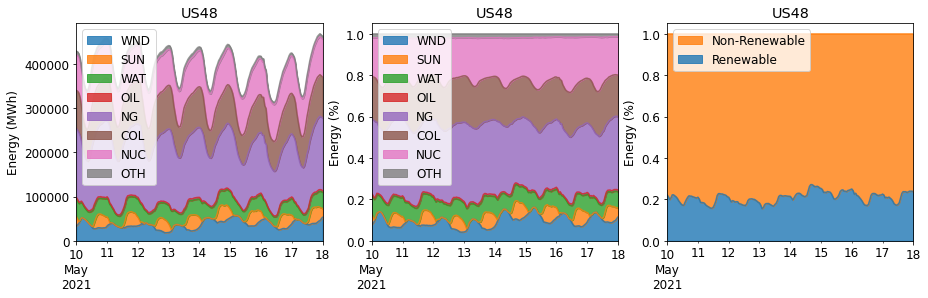

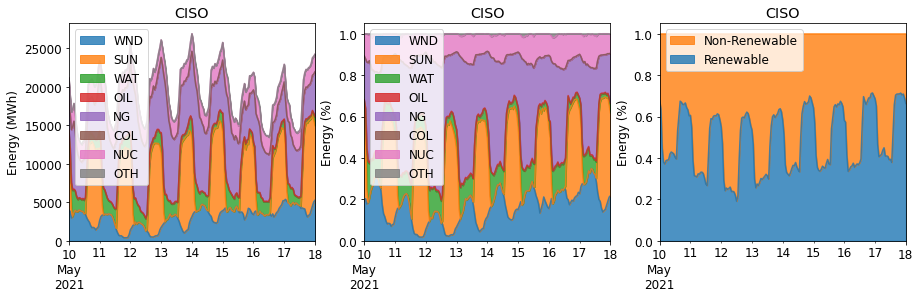

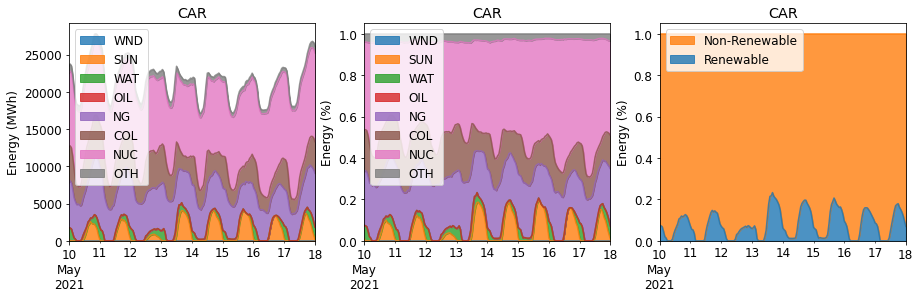

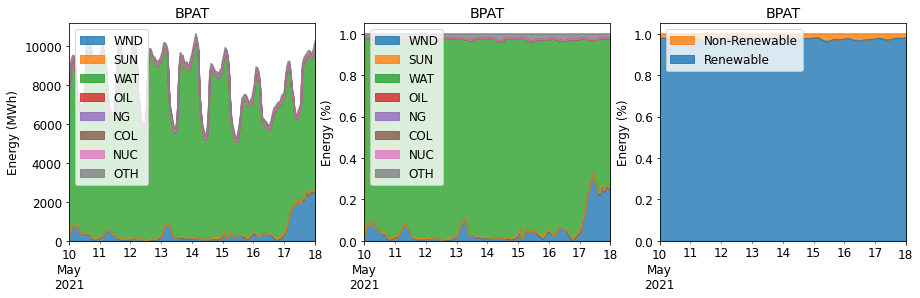

In [45]:
from functools import reduce
# Plot power source
START_DATE = '2021-05-10'
END_DATE = '2021-05-18'
    
# plot grid energy mix of all balancing authorities
#for ba_idx in ba_list:
# plot grid energy mix of selected balancing authorities
for ba_idx in ['US48', 'CISO', 'CAR', 'BPAT']:
    db = extractBARange(ba, START_DATE, END_DATE)
    if(ba_idx != '-'):
        db = extractBARange(ba_idx, START_DATE, END_DATE)
        db[db < 0] = 0
        db = db.resample('H').sum() # Hourly(H) / Daily (D) / Monthly(M) sampling
        db_perc = db.divide(db.sum(axis=1), axis=0)
        db_all = db_perc.sum(axis=1)
        db_cf = db_perc[rn_list].sum(axis=1)
        db_ncf = db_all-db_cf
        result = pd.concat([db_cf, db_ncf], axis=1)
        
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
        ax = db.plot(ax=axes[0], kind='area', stacked=True, title=ba_idx, alpha=0.8)
        ax = db_perc.plot(ax=axes[1], kind='area', stacked=True, title=ba_idx, alpha=0.8)
        ax = result.plot(ax=axes[2], kind='area', stacked=True, title=ba_idx, alpha=0.8)
        axes[0].legend(loc='upper left')
        axes[1].legend(loc='upper left')
        axes[2].legend(reversed(plt.legend().legendHandles), ['Non-Renewable', 'Renewable'], loc='upper left')
        axes[0].set_ylabel("Energy (MWh)")
        axes[1].set_ylabel("Energy (%)")
        axes[2].set_ylabel("Energy (%)")
        plt.show()

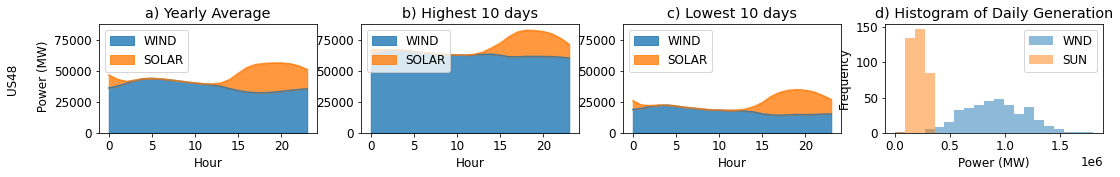

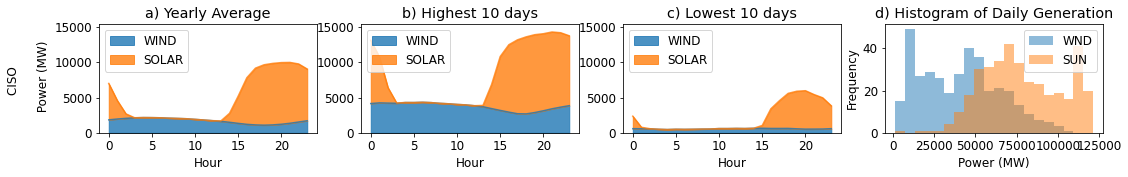

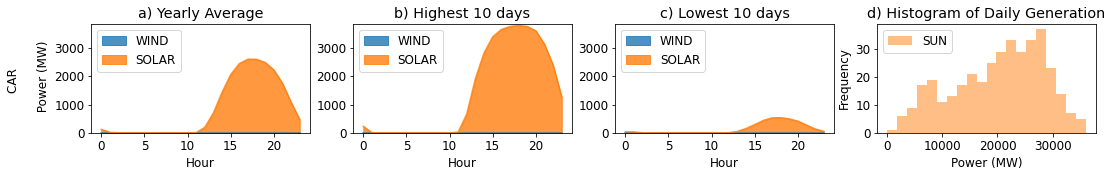

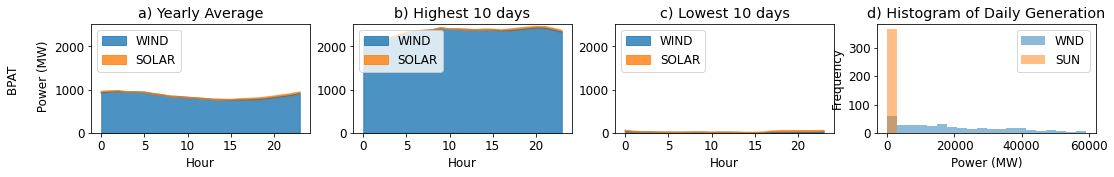

In [44]:
# Analyze yearly wind and solar energy generation distribution
# Generate four plots: daily average generation, highest 10 days, lowest 10 days, and histogram of daily generation

from datetime import date, datetime, timedelta, timezone

YEAR_START = "2020-01-01"
YEAR_END = "2021-01-01"

plt.rcParams.update({"font.size": 12})

# plot all balancing authorities
#for ba_idx in ba_list:
# plot selected balancing authorities
for ba_idx in ['US48', 'CISO', 'CAR', 'BPAT']:
    if ba_idx != "-":
        db = extractBARange(ba_idx, YEAR_START, YEAR_END)
        db[db < 0] = 0
        db = db.resample("H").sum()  # Hourly(H) / Daily (D) / Monthly(M) sampling

        # calculate highest and lowest 10 days of renewables
        # daily sum of wind and solar
        db_daily = db[["WND", "SUN"]].resample("D").sum()
        db_daily_hist = db_daily.reset_index(drop=True)
        if (db_daily_hist["WND"] == 0).all() == True:
            db_daily_hist.drop("WND", axis=1, inplace=True)
        if (db_daily_hist["SUN"] == 0).all() == True:
            db_daily_hist.drop("SUN", axis=1, inplace=True)
        # print(db_daily_hist.min())
        # print((db_daily_hist['WND'] == 0).sum())
        if db_daily_hist.empty:
            print("Balancing authority, ", ba_idx, ', does not have wind or solar energy!')
            continue
    
        db_ren = db_daily.sum(axis=1)

        # largest n days
        db_10_largest_days = db_ren.nlargest(10).index
        df_highest = []
        for i in db_10_largest_days:
            dbi = extractBARange(
                ba_idx,
                i.strftime("%Y-%m-%d"),
                (i + timedelta(days=1)).strftime("%Y-%m-%d"),
            )[:-1]
            dbi[dbi < 0] = 0
            df_highest.append(dbi)
        df_highest = pd.concat(df_highest)

        # print(db_10_lowest_days)
        df_all_highest = []
        # calculate hourly average of the lowest
        for h in range(0, 24, 1):
            d = df_highest.iloc[h::24, :].mean(axis=0)
            df_all_highest.append(d)
        df_all_highest = pd.concat(df_all_highest)
        dwnd = df_all_highest["WND"].to_frame("WIND").reset_index()
        dwnd = dwnd.drop(["index"], axis=1)
        dsol = df_all_highest["SUN"].to_frame("SOLAR").reset_index()
        dsol = dsol.drop(["index"], axis=1)
        df_hourly_highest = pd.concat(
            [dwnd, dsol],
            axis=1,
        )

        # lowest 10 days
        db_10_lowest_days = db_ren.nsmallest(10).index
        df_lowest = []
        for i in db_10_lowest_days:
            dbi = extractBARange(
                ba_idx,
                i.strftime("%Y-%m-%d"),
                (i + timedelta(days=1)).strftime("%Y-%m-%d"),
            )[:-1]
            dbi[dbi < 0] = 0
            df_lowest.append(dbi)
        df_lowest = pd.concat(df_lowest)

        df_all_lowest = []
        # calculate hourly average of the lowest
        for h in range(0, 24, 1):
            d = df_lowest.iloc[h::24, :].mean(axis=0)
            df_all_lowest.append(d)
        df_all_lowest = pd.concat(df_all_lowest)
        dwnd = df_all_lowest["WND"].to_frame("WIND").reset_index()
        dwnd = dwnd.drop(["index"], axis=1)
        dsol = df_all_lowest["SUN"].to_frame("SOLAR").reset_index()
        dsol = dsol.drop(["index"], axis=1)
        df_hourly_lowest = pd.concat(
            [dwnd, dsol],
            axis=1,
        )

        # average of all days
        df_all = []
        # calculate hourly average
        for h in range(0, 24, 1):
            d = db.iloc[h::24, :].mean(axis=0)
            df_all.append(d)
        df_all = pd.concat(df_all)
        dwnd = df_all["WND"].to_frame("WIND").reset_index()
        dwnd = dwnd.drop(["index"], axis=1)
        dsol = df_all["SUN"].to_frame("SOLAR").reset_index()
        dsol = dsol.drop(["index"], axis=1)
        df_hourly = pd.concat(
            [dwnd, dsol],
            axis=1,
        )

        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 2))
        ylim = df_hourly_highest["SOLAR"].max() + df_hourly_highest["WIND"].max() + 50
        for i in range(0, 3):
            if i == 0:
                d = df_hourly
                title = "a) Yearly Average"
            elif i == 1:
                d = df_hourly_highest
                title = "b) Highest 10 days"
            elif i == 2:
                d = df_hourly_lowest
                title = "c) Lowest 10 days"
            axes[i].set_xlabel("Hour")
            ax = d.plot(ax=axes[i], kind="area", stacked=True, title=title, alpha=0.8)
            axes[i].legend(loc="upper left")
            axes[i].set_ylim(0, ylim)
        title4 = "d) Histogram of Daily Generation"
        axes[3].set_xlabel("Power (MW)")
        color_dict = {"WND": "#1f77b4", "SUN": "#ff7f0e"}
        db_daily_hist.plot.hist(
            bins=20,
            alpha=0.5,
            ax=axes[3],
            title=title4,
            color=[color_dict.get(x, "#333333") for x in db_daily_hist.columns],
        )
        axes[0].set_ylabel(ba_idx + " \n\n Power (MW)")
        plt.show()

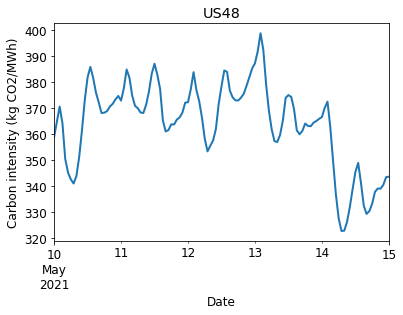

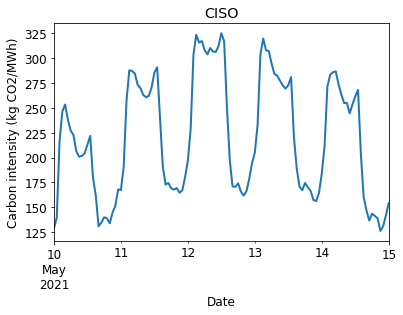

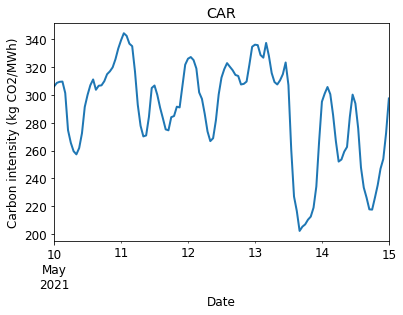

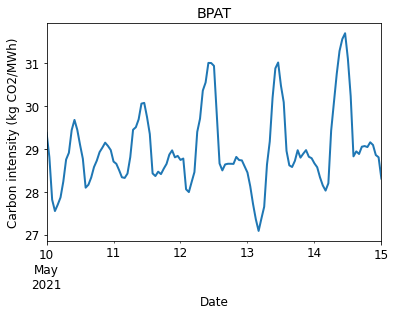

In [51]:
START_DATE = '2021-05-10'
END_DATE = '2021-05-15'

# Plot carbon intensity of the grids

# plot grid energy mix of all balancing authorities
#for ba_idx in ba_list:
# plot grid energy mix of selected balancing authorities
for ba_idx in ['US48', 'CISO', 'CAR', 'BPAT']:
    db = extractBARange(ba_idx, START_DATE, END_DATE)
    db[db < 0] = 0
    sum_db = db.sum(axis=1) 
    tot_carbon = None
    for c in carbon_intensity:
        if tot_carbon is None:
            tot_carbon = carbon_intensity[c]*db[c]
        else:
            tot_carbon = tot_carbon + carbon_intensity[c]*db[c]
    tot_carbon = tot_carbon.div(sum_db)

    ax = tot_carbon.plot(kind='line', stacked=False, title=ba_idx, lw=2)

    ax.set_xlabel("Date")
    ax.set_ylabel('Carbon intensity (kg CO2/MWh)')
    plt.show()
